In [1]:
from qwak.qwak import QWAK
import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp
from utils.plotTools import plot_qwak, plot_qwak_heatmap
import math
import copy
import os
import seaborn as sns
import pandas as pd


In [2]:
def write_nested_list_to_file(file_path, nested_lst):
    """
    Write a nested list of elements to a text file.
    
    :param file_path: the file path where to write the nested list
    :param nested_lst: the nested list of elements to write
    """
    with open(file_path, 'w') as f:
        for lst in nested_lst:
            for item in lst:
                f.write(f"{item} ")
            f.write("\n")

def load_nested_list_from_file(file_path):
    """
    Load a nested list of float elements from a text file.
    
    :param file_path: the file path to load the nested list from
    :return: the nested list of float elements loaded from the file
    """
    nested_lst = []
    with open(file_path, 'r') as f:
        for line in f:
            lst = [float(item) for item in line.strip().split()]
            nested_lst.append(lst)
    return nested_lst

# Single walk search

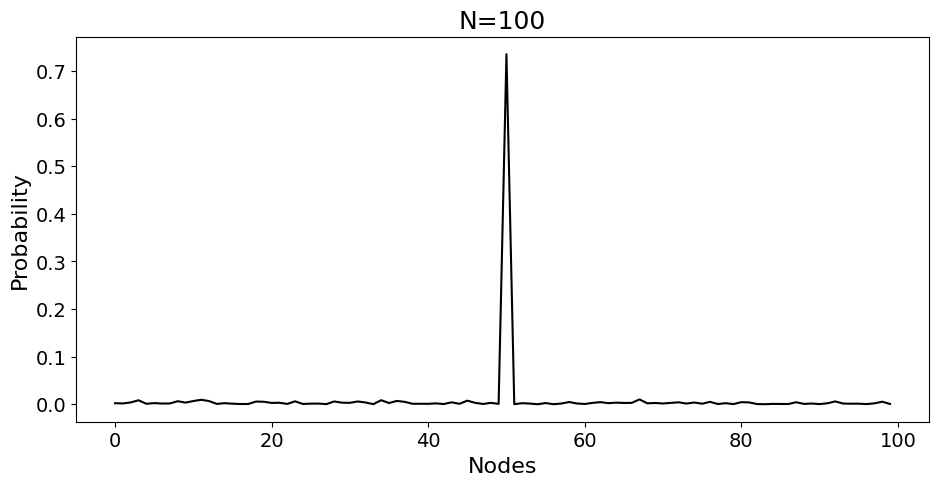

In [4]:
N = 100
pThresh = math.log(N,3/2)/N

t = np.pi/2 * np.sqrt(N)

timeList = [ x for x in np.linspace(t-t/3,t,5)]
markedElements = [(N//2,-1)]
probDistList = []

graph = nx.erdos_renyi_graph(N,pThresh)
if pThresh>1:
    gamma = 1/N
else:
    gamma = 1/(N*pThresh)
initCond = list(range(0,len(graph)))
qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
qw.runWalk(time=t,initStateList=initCond)

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'N={N}',
    'x_label' : 'Nodes',
    'y_label' : "Probability",
    'legend_labels' : None,
    'legend_loc': "best",
    'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#000000'],
    'line_style_list' : ['-'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None
}
plot_qwak(x_value_matrix = list(range(0,N)), y_value_matrix = qw.getProbVec(),**params)

# Heatmap - Multiple walks

In [5]:
def searchProbStepsPlotting2(qwak: QWAK, probDistList):
    """Plots the probability of finding the target as a function of the number of steps.

    Parameters
    ----------
    qwak : QWAK
        QWAK object containing the results of the simulation.
    """
    markedProbability = 0
    markedProbDistList = []
    markdElements = qwak.getMarkedElements()
    probDistList = probDistList
    if probDistList == []:
        raise EmptyProbDistList(
            "The probability distribution list is empty.")
    for probDist in probDistList:
        for element in markdElements:
            markedProbability += probDist.searchNodeProbability(
                element[0])
        markedProbDistList.append(markedProbability)
        markedProbability = 0
    return markedProbDistList

def multiple_erdos_renyi_qwak(N,pList,timeList,numberOfWalks,markedElements):
    markedProbMatrix = []
    markedProbList = [0]*len(timeList)
    probDistList = []
    pValMatrix = []
    sampleCounter = 1
    for pVal in pList:
        print(f'PVAL {round(pVal, 4)}/{max(pList)} \t Sample {sampleCounter}/{len(pList)}')
        sampleCounter += 1
        for i in range(numberOfWalks):
            graph = nx.erdos_renyi_graph(N,pVal)
            if pVal>1:
                gamma = 1/N
            else:
                gamma = 1/(N*pVal)
            initCond = list(range(0,len(graph)))
            qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
            for t in timeList:
                # print(f'NWALK {i} \t PVAL {round(pVal,4)}/{max(pList)} \tTIME {t} /{max(timeList)}')
                qw.runWalk(time=t,initStateList=initCond)
                probDistList.append(copy.deepcopy(qw.getProbDist()))
            markedElementList = searchProbStepsPlotting2(qw,probDistList)
            markedProbList = [x + y for x, y in zip(markedProbList, markedElementList )]
            probDistList = []
        pValMatrix.append([pVal]*len(timeList))
        timeMatrix = [timeList]*len(timeList)
        markedProbListAvg = [x/numberOfWalks for x in markedProbList]
        markedProbMatrix.append(markedProbListAvg)
        markedProbList = [0]*len(timeList)

    return pValMatrix,timeMatrix,markedProbMatrix

In [6]:
n = 9
N = 2**n
p = math.log(N,3/2)/N
pMax = 0.5
samples = 200
numberOfWalks = 40
t = np.pi/2 * np.sqrt(N)
markedElements = [(0,-1)]

pAux = p/(samples)
# pList = np.concatenate([np.linspace(p/10, p-pAux, samples//3),np.linspace(p,p+pAux,samples//3),np.linspace(p+pAux+(pAux/samples), 1.1,samples//3)])
pList = np.linspace(pAux, pMax, samples)
graphList = [nx.erdos_renyi_graph(N,pVal) for pVal in pList]


tAux = t/(samples)
# timeList = np.concatenate([np.linspace(0, t/2 - tAux, samples//3),np.linspace(t/2,t+tAux,samples//3),np.linspace(t,2*t,samples//3)])
timeList = np.linspace(0, 2*t, samples)

In [7]:
time_file = f'Datasets/ERSearch/timeMatrix_N{N}_NGRAPHS{numberOfWalks}_S{samples}_PMAX{pMax}.txt'
pval_file = f'Datasets/ERSearch/pValMatrix_N{N}_NGRAPHS{numberOfWalks}_S{samples}_PMAX{pMax}.txt'
marked_prob_file = f'Datasets/ERSearch/markedProbMatrix_N{N}_NGRAPHS{numberOfWalks}_S{samples}_PMAX{pMax}.txt'

if os.path.exists(time_file) and os.path.exists(pval_file) and os.path.exists(marked_prob_file):
    x = load_nested_list_from_file(pval_file)
    y = load_nested_list_from_file(time_file)
    z = load_nested_list_from_file(marked_prob_file)
    print('File exists!')
else:
    print('File Doesnt Exist!')
    # x,y,z = multiple_erdos_renyi_qwak(N,pList,timeList,numberOfWalks,markedElements)
    x,y,z = multiple_erdos_renyi_qwak2(N,graphList,pList,timeList,numberOfWalks,markedElements)
    # x,y,z = multiple_erdos_renyi_qwak3(N,graphList,pList,timeList,numberOfWalks,markedElements)
    if not os.path.exists(pval_file):
        write_nested_list_to_file(pval_file, x)
    if not os.path.exists(time_file):
        write_nested_list_to_file(time_file, y)
    if not os.path.exists(marked_prob_file):
        write_nested_list_to_file(marked_prob_file, z)

File exists!


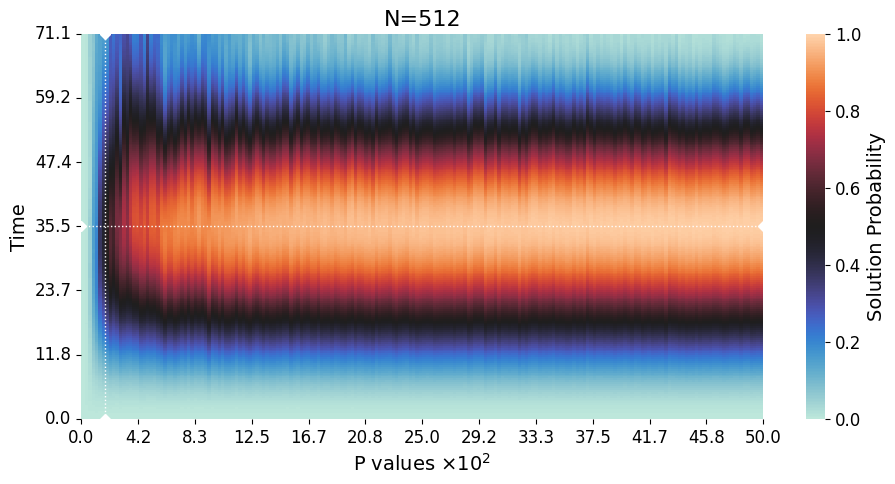

In [8]:
newP = math.log(N,2)/N

x_num_ticks =13
y_num_ticks = 7
x_round_val = 1
y_round_val = 1

xlabel = r'P values $\times 10^2$'
ylabel = 'Time'
cbar_label = 'Solution Probability'

font_size = 12
figsize = (11, 5)
# colormap = "magma"
# colormap = "vlag"
# colormap = sns.diverging_palette(220, 20, as_cmap=True)
colormap = sns.color_palette("icefire", as_cmap=True)
x_vline_value = newP
# x_vline_value = p
y_vline_value = t


heatMapPlotFile = f'Output/ERSearch/heatMapPlot_N{N}_NGRAPHS{numberOfWalks}_S{samples}_PMAX{pMax}.png'
params = {
    'x_num_ticks' : x_num_ticks,
    'y_num_ticks' : y_num_ticks,
    'x_round_val' : x_round_val,
    'y_round_val' : y_round_val,
    'filepath' : heatMapPlotFile,
    'N' : N,
    'xlabel': xlabel,
    'ylabel': ylabel,
    'cbar_label' : cbar_label,
    'font_size' : font_size,
    'figsize' : figsize,
    'cmap' : colormap,
    'x_vline_value' : x_vline_value,
    'y_hline_value' : y_vline_value,
    }


plot_qwak_heatmap(p_values=x, t_values=y, prob_values=z, **params)